In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d
import time

nside = 1024
lmax = 1024*3-1

def iqu2teb(IQU, nside, lmax=None):
    print('a')
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    print('b')
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Signal covariance

In [5]:
ell_ee, cell_ee = np.load('data/namaster_buzzard.npy')
cell_func = interp1d(np.hstack([ell_ee, [ell_ee[-1]+1,1e4]]),
                     np.hstack([cell_ee, [cell_ee[-10]*0.5,1e-15]]),
                     fill_value='extrapolate', kind='linear')

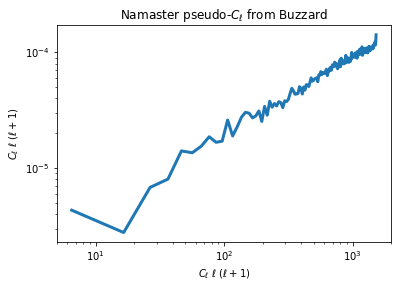

In [6]:
_ = plt.loglog(ell_ee, cell_ee* ell_ee *(ell_ee+1), linewidth=3)
_  =plt.ylabel(r'$C_\ell \ \ell \ (\ell+1)$')
_  =plt.xlabel(r'$C_\ell \ \ell \ (\ell+1)$')
_ = plt.title(r'Namaster pseudo-$C_\ell$ from Buzzard')

In [7]:
ell_cov, mmm_cov = hp.Alm.getlm(nside*3-1)
s_cov_diag =  cell_func(ell_cov)

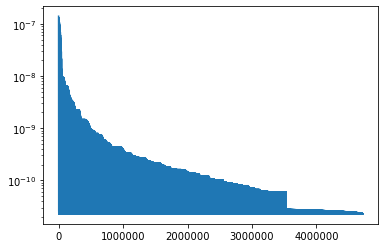

In [12]:
_ = plt.plot(s_cov_diag), plt.yscale('log')

# Data

In [14]:
data_QU = hp.read_map('./map_mock_des1024_QU.fits', field=(0,1))
data_vec = data_QU[0] + 1j* data_QU[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


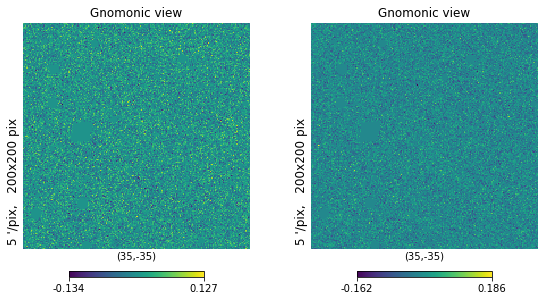

In [15]:
_ = plt.figure(figsize = (12,4)), hp.gnomview(data_vec.real, sub=(1,3,2), reso=5, rot = (35,-35))
_ = hp.gnomview(data_vec.imag, sub=(1,3,3), reso=5, rot = (35,-35))

# Noise covariance

In [26]:
noise_diag = hp.read_map('map_noise_cov_des1024_QU.fits', field=(0,1))
noise_diag = noise_diag[0] + noise_diag[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


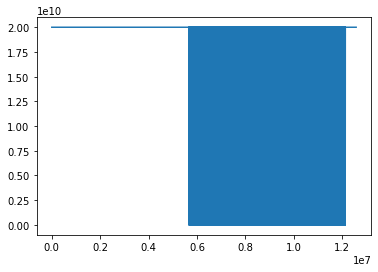

In [27]:
plt.plot(noise_diag)

In [24]:
tau = np.min(noise_diag)
print(tau)
T_pixel = np.ones(noise_diag.shape)*tau
T_harmonic = np.ones(hp.map2alm(data_QU[0], lmax=nside*3-1).shape)*T_pixel[0] / np.float(nside*nside)
print(T_harmonic[0])

0.00034328451147302985
3.2738162181189523e-10


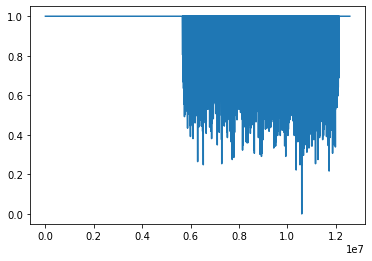

In [25]:
noise_bar_diag = noise_diag - tau
plt.plot(noise_bar_diag/(noise_bar_diag+T_pixel))

# Algorithm

In [56]:
n_iter = 50
s = np.zeros(data_vec.shape, dtype='complex')


T_harmonic_grade = np.ones(hp.map2alm(hp.ud_grade(data_QU[0],1024),
                                      lmax=1024*3-1).shape)*T_pixel[0] / np.float(1024*1024)

s_cov_diag_grade =  cell_func(hp.Alm.getlm(1024*3-1)[0])

harmonic_operator = (s_cov_diag_grade/(s_cov_diag_grade+T_harmonic_grade))
pixel_operator_signal = (noise_bar_diag/(noise_bar_diag+T_pixel))
pixel_operator_data = (T_pixel / (T_pixel + noise_diag))

for i in range(n_iter):
    
    t = pixel_operator_data * data_vec + pixel_operator_signal*s
#     t = hp.ud_grade(t,512)
    
    t_alm1 = hp.map2alm(t.real, lmax = 3*1024-1) 
    t_alm2 = hp.map2alm(t.imag, lmax = 3*1024-1) 
    
    s1 = hp.alm2map(harmonic_operator * t_alm1, nside=1024, lmax=1024*3-1, verbose=False)
    s2 = hp.alm2map(harmonic_operator * t_alm2, nside=1024, lmax=1024*3-1, verbose=False)
    
    s = s1 +1j*s2
    
#     s = hp.ud_grade(s, 128)
#     _ = hp.mollview(s.imag), plt.show()
    print(np.var(s))

1.2407746507590013e-07
2.311421122186461e-07
3.04079704774063e-07
3.556379891147027e-07
3.928817380637459e-07
4.201066381820407e-07
4.40161727301809e-07
4.5502494578550686e-07
4.661010939074801e-07
4.744000895785321e-07
4.806533707438557e-07
4.853935092025137e-07
4.890099774996355e-07
4.917887202820519e-07
4.939404543109408e-07
4.956210188317997e-07
4.969460739025625e-07
4.980017578952155e-07
4.988524433538816e-07
4.995464011518107e-07
5.00119951319991e-07
5.006005151363686e-07
5.010088667272241e-07
5.013607994889765e-07
5.016683632974831e-07
5.019407858716591e-07
5.021851609720524e-07
5.02406963935787e-07
5.026104389642233e-07
5.027988908750287e-07
5.029749054848274e-07
5.031405165291788e-07
5.032973324270566e-07
5.034466328066318e-07
5.035894422026343e-07
5.037265864769885e-07
5.038587361325155e-07
5.039864396592166e-07
5.0411014928249e-07
5.04230240905569e-07
5.043470296049826e-07
5.044607817114446e-07
5.045717242623544e-07
5.046800524258371e-07
5.047859353551312e-07
5.0488952082498

In [68]:
np.var(s_eb1[1])

3.511167998808872e-07

In [69]:
s_eb1 = iqu2teb([s*0.,s.real,s.imag], nside, lmax=nside*3-1)

a
b
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


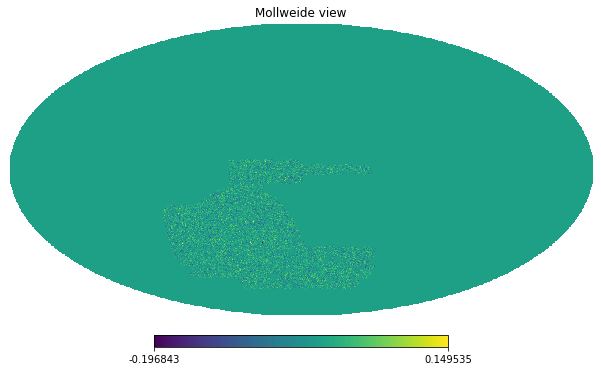

In [70]:
hp.mollview(data_vec.imag)

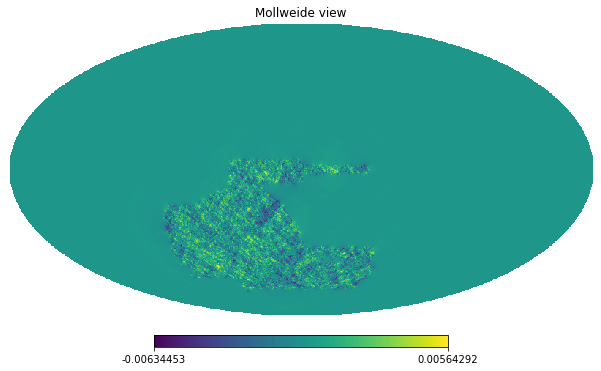

In [71]:
hp.mollview(s.imag)

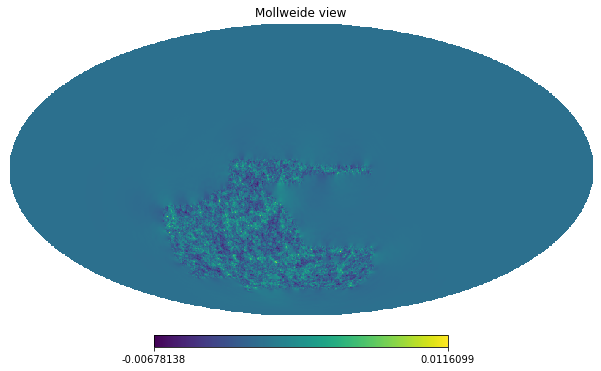

In [72]:
hp.mollview(s_eb1[1])

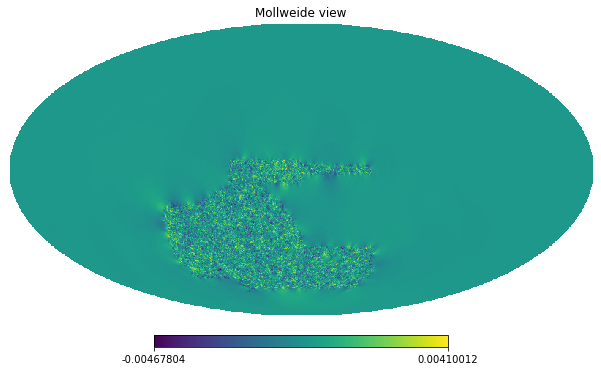

In [73]:
hp.mollview(s_eb1[2])

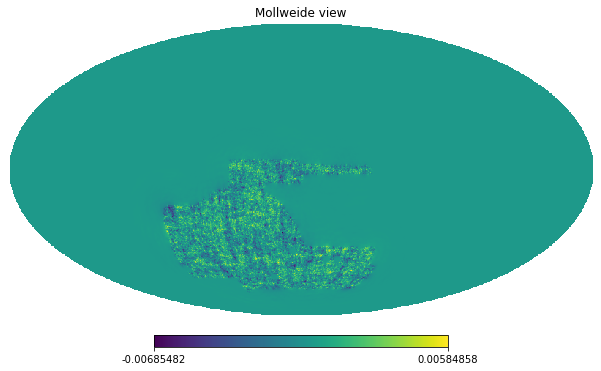

In [74]:
hp.mollview(s.real)

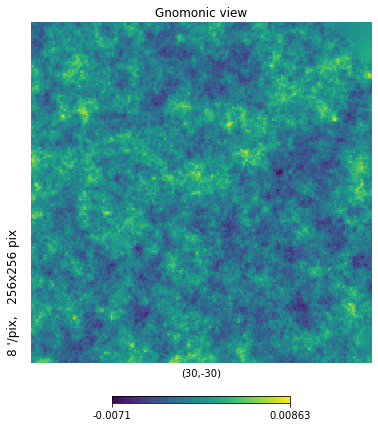

In [75]:
hp.gnomview(s_eb1[1], reso = 8, rot=(30,-30), xsize = 256)

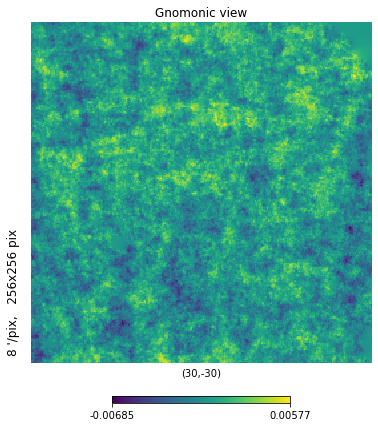

In [76]:
hp.gnomview(s.real, reso = 8, rot=(30,-30), xsize = 256)

In [66]:
np.save('test_wiener180320', s)

In [81]:
np.save('test_wiener1_E_200320', np.array(s_eb1[1], dtype = 'float'))

In [82]:
test_map_eb2 = np.load('test_wiener2_E_200320.npy')

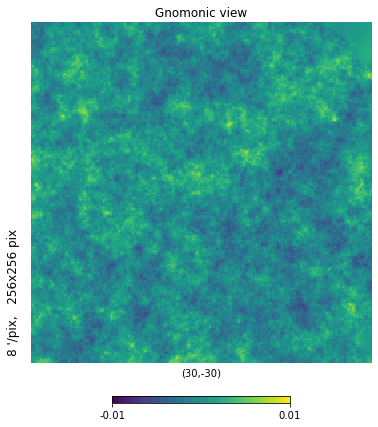

In [87]:
hp.gnomview(s_eb1[1], reso = 8, rot=(30,-30), xsize = 256, min=-0.01, max=0.01)

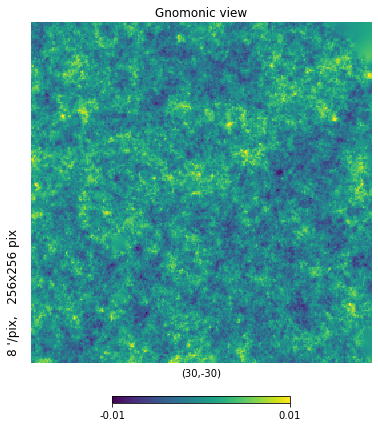

In [88]:
hp.gnomview(test_map_eb2, reso = 8, rot=(30,-30), xsize = 256, min=-0.01, max=0.01)

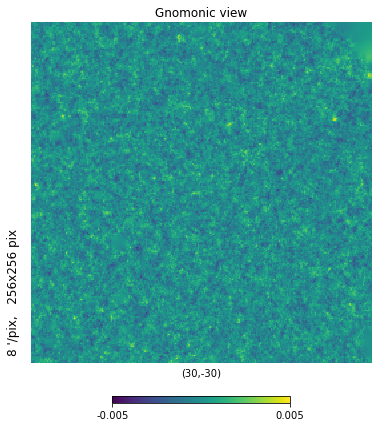

In [90]:
hp.gnomview(test_map_eb2-s_eb1[1], reso = 8, rot=(30,-30), xsize = 256, min=-0.005, max=0.005)